# Programming assignment 4: Implementing linear classifiers

**Goup 15:**
*Neha Devi Shakya, Sarvesh Meenowa, Khushi Chitra Uday*

## Import Libraries

In [ ]:
import time

import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd

from scipy.linalg import blas
from sklearn.base import BaseEstimator
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from aml_perceptron import LinearClassifier, Perceptron, SparsePerceptron, add_sparse_to_dense, sparse_dense_dot

## Exercise question
We are developing a simple system to predict the weather based on our location and the season. Here is a training set.

|   City:       |   Month:      |   Weather:    |
|---------------|---------------|---------------|
|   Gothenburg  |   July        |   rain        |
|   Gothenburg  |   December    |   rain        |
|   Paris       |   July        |   sun         |
|   Paris       |   December    |   rain        |

We build the system by training a perceptron from scikit-learn on this training set. We then test the classifier on the same set. As expected, the classifier correctly classifies all the instances in this set; after all, it's the same set we used to train it, so it seems that classifier has "memorized" the training set.

Now, we repeat this experiment using another training set. We train the classifier using the following examples, and again we evaluate it using the same examples we used to train it.

|   City:   |   Month:      |   Weather:    |
|-----------|---------------|---------------|
|   Sydney  |   July        |   rain        |
|   Sydney  |   December    |   sun         |
|   Paris   |   July        |   sun         |
|   Paris   |   December    |   rain        |

When we use this set, for some strange reason our classifier performs poorly! We can't improve it by switching to a LinearSVC. Do you have an idea what's going on? Why could the classifier "memorize" the training data in the first case, but not in the second case?

[Here](https://www.cse.chalmers.se/~richajo/dit866/files/weather.py) is the Python code if you want to try the experiment yourself.

In [ ]:
X1 = [{'city':'Gothenburg', 'month':'July'},
      {'city':'Gothenburg', 'month':'December'},
      {'city':'Paris', 'month':'July'},
      {'city':'Paris', 'month':'December'}]
Y1 = ['rain', 'rain', 'sun', 'rain']

X2 = [{'city':'Sydney', 'month':'July'},
      {'city':'Sydney', 'month':'December'},
      {'city':'Paris', 'month':'July'},
      {'city':'Paris', 'month':'December'}]
Y2 = ['rain', 'sun', 'sun', 'rain']

classifier1 = make_pipeline(DictVectorizer(), Perceptron(n_iter=10))
classifier1.fit(X1, Y1)
guesses1 = classifier1.predict(X1)
print(accuracy_score(Y1, guesses1))

classifier2 = make_pipeline(DictVectorizer(), Perceptron(n_iter=10))
classifier2.fit(X2, Y2)
guesses2 = classifier2.predict(X2)
print(accuracy_score(Y2, guesses2))

1.0
0.5


In [ ]:
classifier3 = make_pipeline(DictVectorizer(), LinearSVC())
classifier3.fit(X1, Y1)
guesses3 = classifier3.predict(X1)
print(accuracy_score(Y1, guesses3))

classifier4 = make_pipeline(DictVectorizer(), LinearSVC())
classifier4.fit(X2, Y2)
guesses3 = classifier4.predict(X2)
print(accuracy_score(Y2, guesses3))

1.0
0.5


### Case 1:

If we encode the categorical features: city, and month, we obtain : 

    * City: Gothenburg = 1, Paris = 0
    * Month: July = 1, December = 0

If we encode the targets : weather, we ontain: 

    * Weather: rain = 1, sun = 0

Now we can visualize the scatter plot for the encoding.

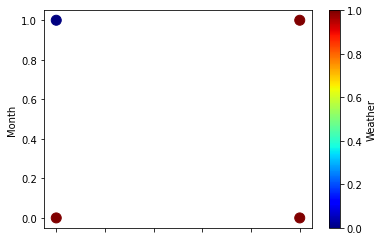

In [ ]:
df_xor1 = pd.DataFrame(
    [[1, 1, 1], [1, 0, 1], [0, 1, 0], [0, 0, 1]],
    columns = ["City", "Month", "Weather"]
)
df_xor1.plot.scatter(x = "City", y = "Month", c = "Weather", colormap = "jet", s = 100)

In this case, the dataset is linearly separable, that is there exists a **w** that gives us perfect classification. Since the dataset is linearly separable, then the perceptron learning algorithm will find a separating w in a
finite number of steps

### Case 2:

If we encode the categorical features: city, and month, we obtain : 

    * City: Sydney = 1, Paris = 0
    * Month: July = 1, December = 0

If we encode the targets : weather, we ontain: 

    * Weather: rain = 1, sun = 0

Now we can visualize the scatter plot for the encoding.

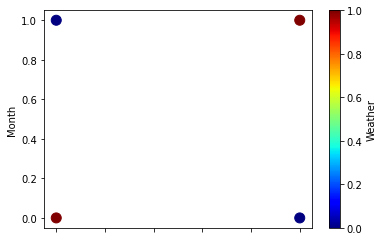

In [ ]:
df_xor2 = pd.DataFrame(
    [[1, 1, 1], [1, 0, 0], [0, 1, 0], [0, 0, 1]],
    columns=["City", "Month", "Weather"]
)
df_xor2.plot.scatter(x = "City", y = "Month", c = "Weather", colormap = "jet", s = 100)

On the other hand, from the plot, we can see that the data is not linearly separable, hence using Perceptron and Linear SVC, there will not be a **w** which will give us perfect classification.

## Introduction
Download and unpack this [zip file](https://www.cse.chalmers.se/~richajo/dit866/assignments/a4/pa4.zip). The package contains the perceptron code presented during one of the lectures (**aml_perceptron.py**). Take a look at the class **Perceptron** and make sure that you understand how the Python code corresponds to the pseudocode in the lecture.

The package also contains a Python program (**doc_classification.py**) that carries out an experiment in document classification. This is the same file that we used in one of the demonstrations for one of the lectures. The task here is to determine whether a product review is positive or negative. The program trains a classifier using our perceptron implementation, and then evaluates the classifier on a test set.

 

Run the experiment code and make sure it works on your machine. Training should take at most a few seconds, and the accuracy should be about 0.80.

In [ ]:
# This function reads the corpus, returns a list of documents, and a list
# of their corresponding polarity labels. 
def read_data(corpus_file):
    X = []
    Y = []
    with open(corpus_file, encoding='utf-8') as f:
        for line in f:
            _, y, _, x = line.split(maxsplit=3)
            X.append(x.strip())
            Y.append(y)
    return X, Y


if __name__ == '__main__':
    
    # Read all the documents.
    X, Y = read_data('data/all_sentiment_shuffled.txt')
    
    # Split into training and test parts.
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2,
                                                    random_state=0)

    # Set up the preprocessing steps and the classifier.
    pipeline = make_pipeline(
        TfidfVectorizer(),
        SelectKBest(k=1000),
        Normalizer(),

        # NB that this is our Perceptron, not sklearn.linear_model.Perceptron
        Perceptron()  
    )

    # Train the classifier.
    t0 = time.time()
    pipeline.fit(Xtrain, Ytrain)
    t1 = time.time()
    print('Training time: {:.2f} sec.'.format(t1-t0))

    # Evaluate on the test set.
    Yguess = pipeline.predict(Xtest)
    print('Accuracy: {:.4f}.'.format(accuracy_score(Ytest, Yguess)));

Training time: 6.16 sec.
Accuracy: 0.7919.


## Implementing the SVC
Implement the Pegasos algorithm for training support vector classifiers by converting the pseudocode in Algorithm 1 in the clarification document (Figure 1 in the original Pegasos paper) into proper Python. Test your implementation by using your own classifier instead of the perceptron in **doc_clasification.py**. It's probably easiest if you start from the existing code, for instance by making a copy of the class **Perceptron**, and then just modify it to implement Algorithm 1.

To solve this task you just have to convert the pseudocode into Python code, but it can be good to try to understand why the algorithm looks as it does. Section 2 in the clarification paper goes through the steps. Understanding this may also make it a bit easier to understand what parts to change when you implement logistic regression (see below).

Find good values for the regularization parameter λ and the number of training steps (That is, either the number of iterations through the training set, or the number of randomly selected training instances if you follow the paper's pseudocode more precisely.). For instance, one might choose to iterate 10 times through the training set and set λ to 1/N, where N is the number of instances in training set.

Sanity check: Your accuracy may vary depending on how you choose to implement the algorithm, but if the accuracy is less than 0.80 you have probably made some mistake.


---

We implemented the Pegasos algorithm for training support vector classifiers by 
converting the pseudocode specified in the clarification document. We test our algorithm with various values for the regularization parameter λ and the number of training steps. In the end 0.001 as the regularization parameter λ gave the highest accuracy but incresing the number of iterations did not have an effect on the accuracy so we decided to stick to 20 iterations.

However, using methods like GridSearchCV or RandomizedSearchCV to find the optimal value for these parameters could help us obtain a better accuracy.

In [ ]:
class PegasosSVC(LinearClassifier):
    """
    A straightforward implementation of the pegasos learning algorithm.
    """

    def __init__(self, n_iter = 20, reg_lambda = 0.001, print_loss = True):
        """
        The constructor can optionally take the parameters
        - n_iter the number of times to iterate through the training set
        - reg_lambda the regularization parameter
        """

        self.n_iter = int(n_iter)
        self.reg_lambda = reg_lambda
        self.print_loss = print_loss

        # Initialize the array for losses
        self.losses = []
        
        # to avoid warnings about using non-defined attributes
        self.w = None

    def fit(self, X, Y):
        """
        Train a linear classifier using the pegasos learning algorithm.
        """

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        self.w = np.zeros(n_features)

        # Pegasos algorithm:
        for i in range(self.n_iter):
            t = 0
            
            for x, y in zip(X, Ye):

                t = t + 1

                # calculate the learning rate, eta
                eta = 1 / (self.reg_lambda * t)

                # Compute the output score for this instance.
                score = x.dot(self.w)

                self.w = (1 - eta * self.reg_lambda) * self.w
                
                self.losses.append(max(0, 1 - y * score))
                
                # If there was an error, update the weights by the hinge loss algorithm
                if y * score < 1:
                    self.w += (eta * y) * x
                #     self.losses.append(1 - y * score)
                # else:
                #   self.losses.append(0)
                
            if i % 2 == 0 and self.print_loss == True:
                avg_loss = sum(self.losses) / len(self.losses)
                print(f"Iteration {i}, average loss: {round(avg_loss, 4)}")
                
                self.w = min(1, (1 / self.reg_lambda) / np.linalg.norm(self.w)) * self.w

In [ ]:
# Set up the preprocessing steps and the classifier.
pipeline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest( k = 1000),
    Normalizer(),
    PegasosSVC()
)

# Train the classifier.
t0 = time.time()
pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print("Training time: {:.2f} sec.".format(t1 - t0))

# Evaluate on the test set.
Yguess = pipeline.predict(Xtest)
print("Accuracy: {:.4f}.".format(accuracy_score(Ytest, Yguess)))

Iteration 0, average loss: 0.5355
Iteration 2, average loss: 0.5355
Iteration 4, average loss: 0.5355
Iteration 6, average loss: 0.5355
Iteration 8, average loss: 0.5355
Iteration 10, average loss: 0.5355
Iteration 12, average loss: 0.5355
Iteration 14, average loss: 0.5355
Iteration 16, average loss: 0.5355
Iteration 18, average loss: 0.5355
Training time: 7.97 sec.
Accuracy: 0.8191.


In [ ]:
def find_lambda(lambda_reg):
    pipeline = make_pipeline(
        TfidfVectorizer(),
        SelectKBest(k = 1000),
        Normalizer(),
        PegasosSVC(reg_lambda = lambda_reg, print_loss = False)
    )

    print(f"For lambda = {lambda_reg}:")

    # Train the classifier.
    t0 = time.time()
    pipeline.fit(Xtrain, Ytrain)
    t1 = time.time()
    print("Training time: {:.2f} sec.".format(t1 - t0))


    # Evaluate on the test set.
    Yguess = pipeline.predict(Xtest)
    print("Accuracy: {:.4f}.\n".format(accuracy_score(Ytest, Yguess)))
    return accuracy_score(Ytest, Yguess)

In [ ]:
lambdas = [0.1, 0.01, 0.001, 0.0001, 0.00001]

test_scores = [find_lambda(i) for i in lambdas]

For lambda = 0.1:
Training time: 4.88 sec.
Accuracy: 0.7104.

For lambda = 0.01:
Training time: 4.75 sec.
Accuracy: 0.7663.

For lambda = 0.001:
Training time: 4.23 sec.
Accuracy: 0.8191.

For lambda = 0.0001:
Training time: 3.81 sec.
Accuracy: 0.8099.

For lambda = 1e-05:
Training time: 3.64 sec.
Accuracy: 0.7768.



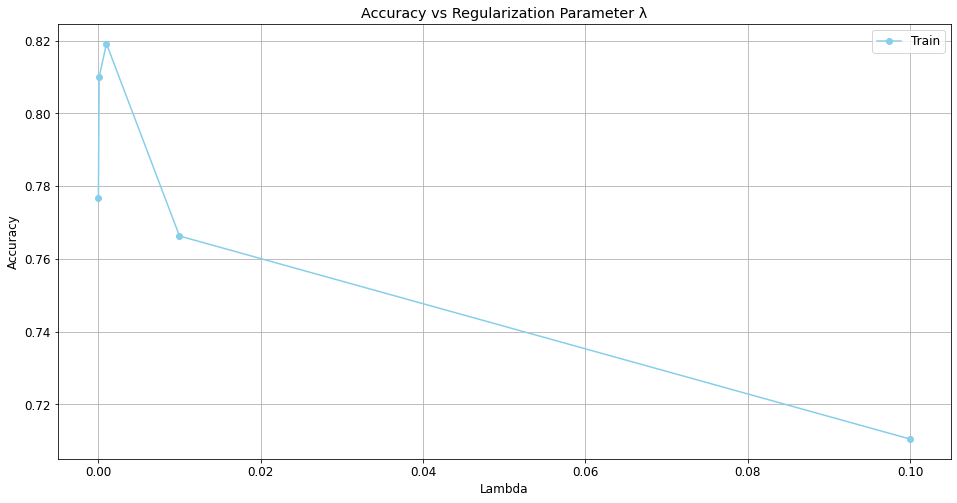

In [ ]:
plt.figure(figsize=(16, 8))
x = np.array(lambdas) # Create domain for plot
plt.rc("font", size = 12) # Set font size to 12

plt.plot(x, test_scores, label = 'Train', color = 'skyblue', marker = 'o', markerfacecolor = 'skyblue') # Plot test scores over domain
plt.title('Accuracy vs Regularization Parameter λ') # Title
plt.xlabel('Lambda') # Label x-axis
plt.ylabel('Accuracy') # Label y-axis
plt.legend() # Show plot labels as legend
plt.grid(axis = "x")
plt.grid(axis = "y") # Show grid x-axis lines

plt.show()

In [ ]:
def find_n_iter(n_iter):
    pipeline = make_pipeline(
        TfidfVectorizer(),
        SelectKBest(k = 1000),
        Normalizer(),
        PegasosSVC(n_iter = n_iter, print_loss = False)  
    )

    print(f"For no of iterations = {n_iter}:")

    # Train the classifier.
    t0 = time.time()
    pipeline.fit(Xtrain, Ytrain)
    t1 = time.time()
    print("Training time: {:.2f} sec.".format(t1 - t0))


    # Evaluate on the test set.
    Yguess = pipeline.predict(Xtest)
    print("Accuracy: {:.4f}.\n".format(accuracy_score(Ytest, Yguess)))
    return accuracy_score(Ytest, Yguess)

In [ ]:
n_iters = [10, 20, 50, 100, 500, 1000]

test_scores = [find_n_iter(i) for i in n_iters]

For no of iterations = 10:
Training time: 2.73 sec.
Accuracy: 0.8191.

For no of iterations = 20:
Training time: 4.15 sec.
Accuracy: 0.8191.

For no of iterations = 50:
Training time: 8.71 sec.
Accuracy: 0.8191.

For no of iterations = 100:
Training time: 16.41 sec.
Accuracy: 0.8191.

For no of iterations = 500:
Training time: 78.31 sec.
Accuracy: 0.8191.

For no of iterations = 1000:
Training time: 154.88 sec.
Accuracy: 0.8191.



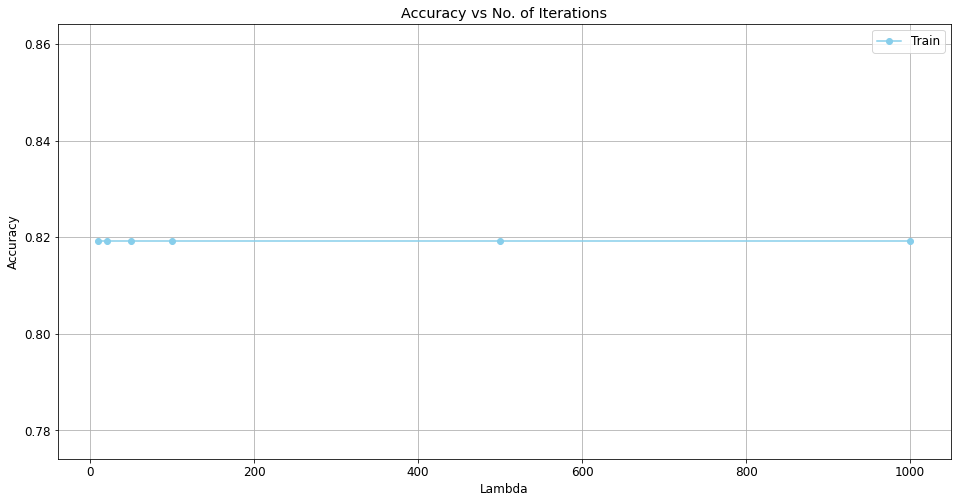

In [ ]:
plt.figure(figsize = (16, 8))
x = np.array(n_iters) # Create domain for plot
plt.rc("font", size = 12) # Set font size to 12

plt.plot(x, test_scores, label = 'Train', color = 'skyblue', marker = 'o', markerfacecolor = 'skyblue') # Plot test scores over domain
plt.title('Accuracy vs No. of Iterations') # Title
plt.xlabel('Lambda') # Label x-axis
plt.ylabel('Accuracy') # Label y-axis
plt.legend() # Show plot labels as legend
plt.grid(axis = "x")
plt.grid(axis = "y") # Show grid x-axis lines

plt.show()

## Logistic regression
As we saw in the lecture, the logistic regression classifier is based on an objective function that looks almost like the one used by the SVC. The difference is just in which loss function is used: the SVC uses the hinge loss and LR the log loss.

Read through the explanation of the log loss and its gradient in section 3 in the clarification document. Or take a look at the table on page 15 in the Pegasos paper: the first line shows the hinge loss and its gradient,[1 (Links to an external site.)] and the second line shows the log loss and the corresponding gradient.

Code a new training algorithm that uses the log loss instead of the hinge loss. Describe how well it works compared to your previous classifier.



---


We implemented the Pegasos algorithm for training logistic regression classifier by using the log loss fuction. Like before we tested our algorithm with various values for the regularization parameter λ and the number of training steps. In the end 0.001 as the regularization parameter λ gave the highest accuracy but incresing the number of iterations did not have an effect on the accuracy so we decided to stick to 20 iterations.

In [ ]:
class PegasosLR(LinearClassifier):
    """
    A straightforward implementation of the pegasos learning algorithm.
    """

    def __init__(self, n_iter = 20, reg_lambda = 0.001, print_loss = True):
        """
        The constructor can optionally take the parameters
        - n_iter the number of times to iterate through the training set
        - reg_lambda the regularization parameter
        """

        self.n_iter = int(n_iter)
        self.reg_lambda = reg_lambda
        self.print_loss = print_loss

        # Initialize the array for losses
        self.losses = []
        
        # to avoid warnings about using non-defined attributes
        self.w = None

    def fit(self, X, Y):
        """
        Train a linear classifier using the pegasos learning algorithm.
        """

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        self.w = np.zeros(n_features)
        
        # Pegasos algorithm:
        for i in range(self.n_iter):
            t = 1
            
            for x, y in zip(X, Ye):

                t += 1

                # calculate the learning rate, eta
                eta = 1 / (self.reg_lambda * t)

                # Compute the output score for this instance.
                score = x.dot(self.w)
                
                self.losses.append(np.log(1 + np.exp(-y * score)))

                # Update the weights by the log loss algorithm
                loss_gradient = y / (1 + np.exp(y * score))
                self.w = (1 - eta * self.reg_lambda) * self.w + loss_gradient * eta * x
                
            if i % 2 == 0 and self.print_loss:
                    avg_loss = sum(self.losses) / len(self.losses)
                    print(f"Iteration {i}, average loss: {round(avg_loss, 4)}")

In [ ]:
# Set up the preprocessing steps and the classifier.
pipeline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest( k = 1000),
    Normalizer(),
    PegasosLR()
)

# Train the classifier.
t0 = time.time()
pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print("Training time: {:.2f} sec.".format(t1 - t0))

# Evaluate on the test set.
Yguess = pipeline.predict(Xtest)
print("Accuracy: {:.4f}.".format(accuracy_score(Ytest, Yguess)))

Iteration 0, average loss: 0.5124
Iteration 2, average loss: 0.5125
Iteration 4, average loss: 0.5125
Iteration 6, average loss: 0.5125
Iteration 8, average loss: 0.5125
Iteration 10, average loss: 0.5125
Iteration 12, average loss: 0.5125
Iteration 14, average loss: 0.5125
Iteration 16, average loss: 0.5125
Iteration 18, average loss: 0.5125
Training time: 5.99 sec.
Accuracy: 0.8082.


The implementaion for Logistic Regression gave a slightly less accuracy compared to SVC (SVC = 0.8191 vs. Logistic Regression = 0.8082). The difference being that logistic regression uses log loss function whereas SVC uses hinge loss function. Because its weight vector is continually changing as information from data is acquired, using the log loss function leads to higher probability estimation at the expense of accuracy as misclassification is not penalized. In contrast, the hinge loss improves accuracy and sparsity at the expense of substantially lower sensitivity to probability because it penalizes misclassification by updating the weight vector only for misclassified data points. The Logistic Regression model likewise takes somewhat longer to train than the SVC model (7.67s vs 5.99s).

### [DONE] Optional task: Printing the value of the objective function
Add some code to print approximate values of the SVM or LR objective function while training. For instance, if your code uses "epochs" (iterations through the training set), it seems natural to print the objective after each epoch. (Otherwise, you might print the objective value every 1,000 or 10,000 instances or so.) Recall that the objective is equal to the mean of the loss function over the whole training set, plus a regularizer term. So each time you process one training instance, you might compute the loss function as well, and add it to the sum of loss values.

## Bonus tasks
To receive 8p or higher (from a total maximum 10p), it is required that you solve one of the following tasks. Please do not solve more than one task. Note that each of the bonus tasks has a number of subtasks that need to be solved.



### Bonus task 1. Making your code more efficient

#### (a) Faster linear algebra operations

In this bonus challenge, we used the following functions from the scipy.linalg.blas library to try to speed up the SVC algorithm: ddot(x, y), dscal(a, x), and daxpy(x, y, a=a). The goal is to increase the speed of the dot product and scalar product operations. These functions are more efficient than normal NumPy linear algebra operations, because they avoid a number of safety checks carried out by NumPy. Furthermore, BLAS functions frequently take advantage of CPU-specific processes based on the current machine and are capable of allowing kernels to execute in parallel to speed up calculations.

##### Pegasos Algorithm For SVC

In [ ]:
class FasterPegasosSVC(LinearClassifier):
    """
    A straightforward implementation of the pegasos learning algorithm.
    """

    def __init__(self, n_iter = 20, reg_lambda = 0.001):
        """
        The constructor can optionally take the parameters
        - n_iter the number of times to iterate through the training set
        - reg_lambda the regularization parameter
        """

        self.n_iter = int(n_iter)
        self.reg_lambda = reg_lambda

        # Initialize the array for losses
        self.losses = []
        
        # to avoid warnings about using non-defined attributes
        self.w = None

    def fit(self, X, Y):
        """
        Train a linear classifier using the pegasos learning algorithm.
        """

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        self.w = np.zeros(n_features)

        # Pegasos algorithm:
        for i in range(self.n_iter):
            t = 1
            
            for x, y in zip(X, Ye):

                t += 1

                # calculate the learning rate, eta
                eta = 1 / (self.reg_lambda * t)

                # Compute the output score for this instance.
                score = blas.ddot(x,self.w)
                
                blas.dscal(1 - blas.dscal(eta, self.reg_lambda), self.w)
                
                self.losses.append(max(0, 1 - y * score))
                
                # If there was an error, update the weights by the hinge loss algorithm
                if y * score < 1:
                    blas.daxpy(x, self.w, a = eta * y)
                
            if i % 2 == 0:
                avg_loss = sum(self.losses) / len(self.losses)
                print(f"Iteration {i}, average loss: {round(avg_loss, 4)}")

In [ ]:
# Set up the preprocessing steps and the classifier.
pipeline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest( k = 1000),
    Normalizer(),
    FasterPegasosSVC()
)

# Train the classifier.
t0 = time.time()
pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print("Training time: {:.2f} sec.".format(t1 - t0))

# Evaluate on the test set.
Yguess = pipeline.predict(Xtest)
print("Accuracy: {:.4f}.".format(accuracy_score(Ytest, Yguess)))

Iteration 0, average loss: 0.5213
Iteration 2, average loss: 0.5212
Iteration 4, average loss: 0.5211
Iteration 6, average loss: 0.5211
Iteration 8, average loss: 0.5211
Iteration 10, average loss: 0.5211
Iteration 12, average loss: 0.5211
Iteration 14, average loss: 0.5211
Iteration 16, average loss: 0.5211
Iteration 18, average loss: 0.5211
Training time: 4.04 sec.
Accuracy: 0.8191.


According to the FasterPegasosSVC results, the training time can be reduced by 47.3% i.e. from 7.67s to 4.04s. The absolute reduction in training time is not particularly impressive for these relatively short training times. However, for longer training times such as a one-hour training session minimising that training time by 47.3% indicates a total reduction of around 28 minutes, which could be quite useful in practice. Also no change in accuracy score was observed indicating that training time can be reduced without sacrificing accuracy.

#### (b) Using sparse vectors

##### Pegasos Algorithm For SVC

In [ ]:
# Set up the preprocessing steps and the classifier.
pipeline = make_pipeline(
    TfidfVectorizer(),
    Normalizer(),
    PegasosSVC()
)

# Train the classifier.
t0 = time.time()
pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print("Training time: {:.2f} sec.".format(t1 - t0))

# Evaluate on the test set.
Yguess = pipeline.predict(Xtest)
print("Accuracy: {:.4f}.".format(accuracy_score(Ytest, Yguess)))

Iteration 0, average loss: 0.6257
Iteration 2, average loss: 0.6258
Iteration 4, average loss: 0.6258
Iteration 6, average loss: 0.6258
Iteration 8, average loss: 0.6258
Iteration 10, average loss: 0.6258
Iteration 12, average loss: 0.6258
Iteration 14, average loss: 0.6258
Iteration 16, average loss: 0.6258
Iteration 18, average loss: 0.6258
Training time: 52.70 sec.
Accuracy: 0.8070.


Removing the feature limitation from the pipeline  (***SelectKBest(k = 1000)***) resulted in longer training time and reduced accuracy. 


---

We developed efficient methods for handling sparse vectors for the SVC classifier, which decreased memory use and speed when running the algorithm without the feature limitation (without SelectKBest(k=1000)). We referred to the SparsePerceptron code to develop the SparsePegasosSVC code implementing the sparse_dense_dot() function when computing the score and add_sparse_to_dense() function when calculating the weight vector.

A sparse matrix comprises mainly zero values that take up unneeded space, which is what we may expect for our data when we remove the feature restriction. As a result, sparse_dense_dot() and add_sparse_to_dense() functions only save the indices and values for each weight related to a feature, saving space by not storing 0 values.

In [ ]:
class SparsePegasosSVC(LinearClassifier):
    """
    A straightforward implementation of the pegasos learning algorithm,
    assuming that the input feature matrix X is sparse.
    """

    def __init__(self, n_iter = 20, reg_lambda = 0.001):
        """
        The constructor can optionally take the parameters
        - n_iter the number of times to iterate through the training set
        - reg_lambda the regularization parameter
        """

        self.n_iter = int(n_iter)
        self.reg_lambda = reg_lambda

        # Initialize the array for losses
        self.losses = []
        
        # to avoid warnings about using non-defined attributes
        self.w = None

    def fit(self, X, Y):
        """
        Train a linear classifier using the pegasos learning algorithm.

        Note that this will only work if X is a sparse matrix, such as the
        output of a scikit-learn vectorizer.
        """
        self.find_classes(Y)

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        Ye = self.encode_outputs(Y)

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        self.w = np.zeros(n_features)

        # Iteration through sparse matrices can be a bit slow, so we first
        # prepare this list to speed up iteration.
        XY = list(zip(X, Ye))

        for i in range(self.n_iter):
            for t, (x, y) in enumerate(zip(X, Ye), start=2):

                # calculate the learning rate, eta
                eta = 1 / (self.reg_lambda * t)

                # Compute the output score for this instance.
                # This corresponds to score = x.dot(self.w) above.
                score = sparse_dense_dot(x, self.w)

                self.w = (1 - eta * self.reg_lambda) * self.w

                self.losses.append(max(0, 1 - y * score))

                # If there was an error, update the weights by the hinge loss algorithm
                if y * score < 1:
                    # This corresponds to self.w += (eta * y) * x above.
                    add_sparse_to_dense(x, self.w, eta * y)

            if i % 2 == 0:
                avg_loss = sum(self.losses) / len(self.losses)
                print(f"Iteration {i}, average loss: {round(avg_loss, 4)}")

In [ ]:
# Set up the preprocessing steps and the classifier.
pipeline = make_pipeline(
    TfidfVectorizer(),
    Normalizer(),
    SparsePegasosSVC()
)

# Train the classifier.
t0 = time.time()
pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print("Training time: {:.2f} sec.".format(t1 - t0))

# Evaluate on the test set.
Yguess = pipeline.predict(Xtest)
print("Accuracy: {:.4f}.".format(accuracy_score(Ytest, Yguess)))

Iteration 0, average loss: 0.6178
Iteration 2, average loss: 0.6176
Iteration 4, average loss: 0.6175
Iteration 6, average loss: 0.6175
Iteration 8, average loss: 0.6175
Iteration 10, average loss: 0.6175
Iteration 12, average loss: 0.6175
Iteration 14, average loss: 0.6175
Iteration 16, average loss: 0.6175
Iteration 18, average loss: 0.6175
Training time: 38.73 sec.
Accuracy: 0.8070.


Comparing the SparsePegasosSVC result to the PegasosSVC result, it was possible to lower the running time by 26.5%, i.e. from 52.70s to 38.73s. Not storing the zero values in the weight vector made it possible to save some memory during the calculations and the changes are more comprehensive than those made in task 1A. However, because the datasets in tasks 1A and 1B are not similar due to the difference in feature count, these improvements cannot be considered equal.

#### (c) Speeding up the scaling operation

We used SparsePegasosSVC as the starting point for the new changes implemented for this task. Previously we scaled the weight vector for each iteration; however, this is not required because we can merely update the scaling factor in each iteration and then multiply the scaling factor with the weight vector after all iterations have been completed. This update streamlines the calculations, resulting in a reduced training time.

In [ ]:
class ScaledPegasosSVC(LinearClassifier):
    """
    A straightforward implementation of the pegasos learning algorithm,
    assuming that the input feature matrix X is sparse.
    """

    def __init__(self, n_iter = 20, reg_lambda = 0.001):
        """
        The constructor can optionally take the parameters
        - n_iter the number of times to iterate through the training set
        - reg_lambda the regularization parameter
        """

        self.n_iter = int(n_iter)
        self.reg_lambda = reg_lambda

        # Initialize the array for losses
        self.losses = []
        
        # to avoid warnings about using non-defined attributes
        self.w = None

    def fit(self, X, Y):
        """
        Train a linear classifier using the pegasos learning algorithm.

        Note that this will only work if X is a sparse matrix, such as the
        output of a scikit-learn vectorizer.
        """
        self.find_classes(Y)

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        Ye = self.encode_outputs(Y)

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        self.w = np.zeros(n_features)
        
        # Initialize the scaling factor
        a = 1.0

        # Iteration through sparse matrices can be a bit slow, so we first
        # prepare this list to speed up iteration.
        XY = list(zip(X, Ye))

        # Pegoses algorithm:
        for i in range(self.n_iter):
            t = 1
            
            for x, y in  XY:

                t += 1

                # calculate the learning rate, eta
                eta = 1 / (self.reg_lambda * t)
                
                # Compute the output score for this instance.
                # (This corresponds to score = x.dot(self.w) above.)
                score = a *  sparse_dense_dot(x, self.w)
                
                a = (1 - eta * self.reg_lambda) * a

                if a == 0.:
                    a = 1e-9
                
                # self.w = (1 - eta * self.reg_lambda) * self.w
                
                self.losses.append(max(0, 1 - y * score))
                
                # If there was an error, update the weights by the hinge loss algorithm
                if y * score < 1:
                    # This corresponds to self.w += ((eta * y) / a) * x
                    add_sparse_to_dense(x, self.w, (eta * y) / a)
                
            if i % 2 == 0:
                avg_loss = sum(self.losses) / len(self.losses)
                print(f"Iteration {i}, average loss: {round(avg_loss, 4)}")
                
            # self.w = min(1, (1 / self.reg_lambda) / np.linalg.norm(self.w)) * self.w
            
        self.w *= a

In [ ]:
# Set up the preprocessing steps and the classifier.
pipeline = make_pipeline(
    TfidfVectorizer(),
    Normalizer(),
    ScaledPegasosSVC()
)

# Train the classifier.
t0 = time.time()
pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print("Training time for sparse SVC: {:.2f} sec.".format(t1 - t0))

# Evaluate on the test set.
Yguess = pipeline.predict(Xtest)
print("Accuracy for sparse SVC: {:.4f}.".format(accuracy_score(Ytest, Yguess)))

Iteration 0, average loss: 0.6178
Iteration 2, average loss: 0.6176
Iteration 4, average loss: 0.6175
Iteration 6, average loss: 0.6175
Iteration 8, average loss: 0.6175
Iteration 10, average loss: 0.6175
Iteration 12, average loss: 0.6175
Iteration 14, average loss: 0.6175
Iteration 16, average loss: 0.6175
Iteration 18, average loss: 0.6175
Training time for sparse SVC: 6.73 sec.
Accuracy for sparse SVC: 0.8070.


When comparing the results for ScaledPegasosSVC to SparsePegasosSVC, it was possible to cut the running time by 82.6%, from 38.73s to 6.73s.